# Conformal Predictions for ML Models (Dupont)

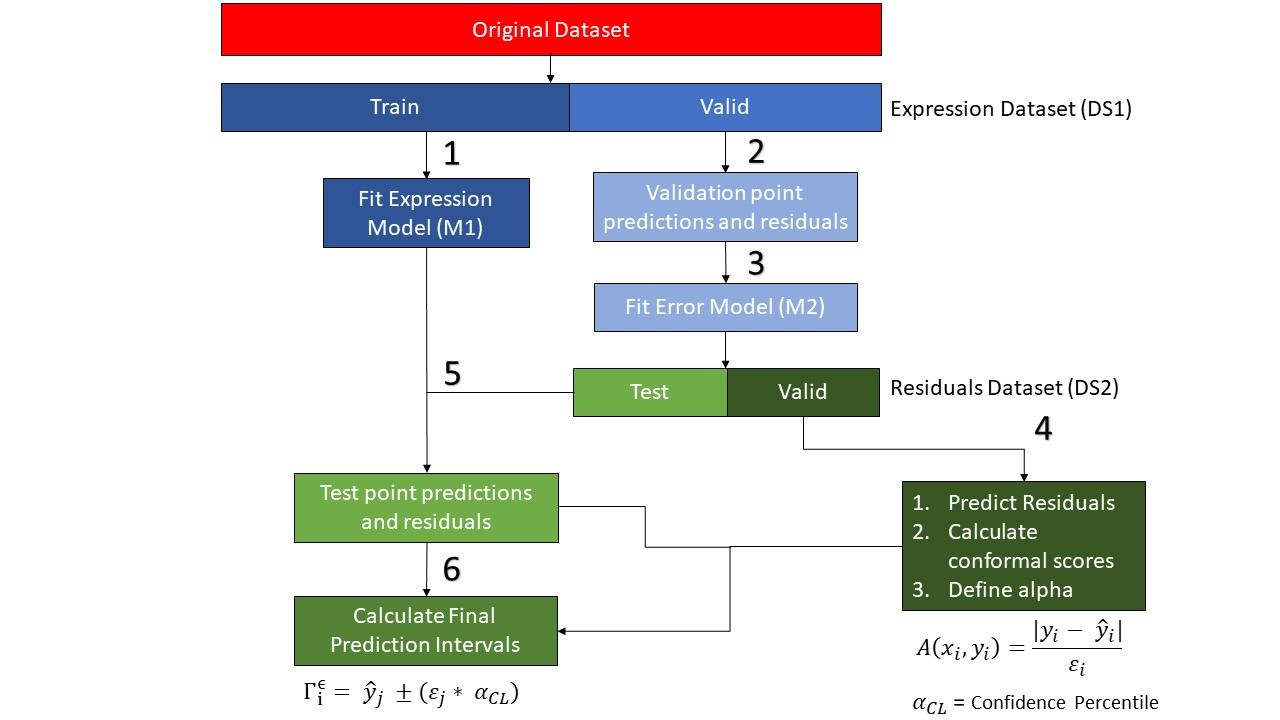

## Library Imports

Prepare necessary modules and environments for notebook

In [1]:
#Load Modules
import dotenv
dotenv.load_dotenv(".env")
import prolerep.analysis.utils as utils
import mlflow.sklearn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import pandas.api.types as pdtypes
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
original_dataset = utils.read_csv_from_s3("s3://prolerep/datasets/galapagos_38.csv.gz") #Upload original dataset from MLFlow
#original_dataset.head()

**Step 1:** Load Expression_Model (Underlying Model)
* *Note: This model was previously trained to predict expression as target*

In [3]:
runs = mlflow.search_runs(39)
cols = ["run_id", "params.model_name", "metrics.valid_r_square", "metrics.train_r_square", "params.prepared_dataset_uri"]
best = (
    runs
    .sort_values("metrics.valid_r_square", ascending=False)
    .groupby("params.model_name")
    .head(n=1)
    [cols]
    .set_index("params.model_name")
)
best

,run_id,metrics.valid_r_square,metrics.train_r_square,params.prepared_dataset_uri
params.model_name,,,,
ScikitBertRun,4d9eebfe19df40e683bac07ad138695b,0.661065,0.787768,s3://mlflow/39/58bc3c9f00204dbea3a8a6d36b95bbe...
OneHotRun,fac1135195974b79961c3e3014176b99,0.590923,0.660392,s3://mlflow/39/81482ebf74e44f2a8b75b137bbc8ce5...
EinsumRun,1bf969d9303744aaa01a8a45e4db722c,0.570614,0.588919,s3://mlflow/39/58bc3c9f00204dbea3a8a6d36b95bbe...
PLSRun,d878a1f0724b4455b013c46137788677,0.473639,0.552007,s3://mlflow/39/58bc3c9f00204dbea3a8a6d36b95bbe...
NaN,81482ebf74e44f2a8b75b137bbc8ce52,NaN,NaN,None


In [4]:
'Underyling Predictive Model: Target for Expression Levels'
stability_model = mlflow.sklearn.load_model(f"runs:/{best.loc['ScikitBertRun'].run_id}/logged_model")
#stability_model

**Step 2:** Load Expression Dataset from MLFlow

In [5]:
stability_df = utils.read_csv_from_s3(best.loc['ScikitBertRun']["params.prepared_dataset_uri"]) #Upload split dataset from MLFlow
stability_df.head()

,temperature,detergent,sequence,stability,split
0,25.0,Ariel,-AQQVPWGISRVQAPAAH-NRGLRGSGVKVAVLDTGI-STHPDLNI...,0.810785,train
1,25.0,Ariel,-AQQVPWGISRVQAPAAH-NRGLRGSGVKVAVLDTGI-STHPDLNI...,1.000000,train
2,25.0,Ariel,-AQQVPYGVSQIKAPALH-SQGYYGQNVKVAVIDTGIDSSHPDLKV...,0.920799,train
3,40.0,PNB,-AQSVPWGISHVQAPAAH-NRGLAGSGVKVAVLDTGI-STHPDLNI...,0.191290,valid
4,40.0,PNB,-AQSVPWGISRVQAPAAH-NHGLAGSGVKVAVLDTGI-STHPDLNI...,0.655244,train


**Step 3:** Seperate dataset into train and validation

In [6]:
def expression_data_split(df):
    #df = df[["sequence", "new_host", "split", "expression"]]  # rearrange dataframe columns
    train = df.loc[df["split"] == "train"]
    valid = df.loc[df["split"] == "valid"]
    # Expression Data
    x_train = train[["sequence", "detergent", "split", "temperature"]]
    y_train = train[["stability"]]
    x_valid = valid[["sequence", "detergent", "split", "temperature"]]
    y_valid = valid[["stability"]]
    #Convert y dataframes into arrays
    y_valid = y_valid.values
    y_train = y_train.values
    print("Data has been split")
    print("x_train and y_train shape: "+ str(x_train.shape) + str(y_train.shape))
    print("x_valid and y_valid shape: "+ str(x_valid.shape) + str(y_valid.shape))
    print('{} instances, {} features, {} classes'.format(y_train.size,
                                                   x_train.shape[1],
                                                   np.unique(y_train).size))
    return x_train, x_valid, y_train, y_valid

In [7]:
x_train, x_valid, y_train, y_valid = expression_data_split(stability_df)

Data has been split
x_train and y_train shape: (17163, 4)(17163, 1)
x_valid and y_valid shape: (4286, 4)(4286, 1)
17163 instances, 4 features, 14347 classes


**Step 4:** Calculate point predictions


In [8]:
valid_point_predictions = stability_model.predict(x_valid)
valid_point_predictions = valid_point_predictions.reshape(-1, 1)
print("Point predictions have been estabilshed")

/home/john/my_python_env/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


Point predictions have been estabilshed


**Step 5**: Revise Expression Model Performance

In [9]:
print("R2 score : %.2f" % r2_score(y_valid, valid_point_predictions))
print("MSE score : %.2f" % mean_squared_error(y_valid, valid_point_predictions))

R2 score : 0.66
MSE score : 0.04


**Step 6:** Determine prediction errors of point predictions in calibration set

In [10]:
def calculate_residuals(predictions, true_labels):
    '''
    Calculates residuals of predicted labels vs true_labels 
    For each correct output in ``y``, nonconformity is defined as
    math::
    | y_i (predicted labels) - y^_i (true labels) |     
    
    @params
    true_labels is a numpy array of (true) labels 
    predictions is a numpy array of predicted labels
        
    Returns:
    Residual scores: numpy array of shape [n_samples]
    Residual scores of samples
    '''
    true_labels =  true_labels.flatten()
    predictions = predictions.flatten()
    residuals = np.abs(predictions - true_labels)
    
    print("Residuals have been calcualted ")
        
    return residuals

In [11]:
underlying_residuals = calculate_residuals(valid_point_predictions, y_valid)
underlying_residuals

Residuals have been calcualted 


array([0.31212005, 0.1077005 , 0.09978578, ..., 0.08202751, 0.4347478 ,
       0.26910927])

**Step 7:** Create new dataset (For training residuals model)

In [12]:
def create_residuals_df(x_valid):
    task = ['residuals'] * len(x_valid)
    x_valid['task'] = task
    x_valid['output'] = underlying_residuals
    x_valid['stability'] = y_valid
    
    return x_valid

In [14]:
#residuals_df = create_residuals_df(x_valid)
#residuals_df.to_csv(r'/home/john/Experiments/Stability_Residuals/BERT_Residuals/dataframe_residuals_stability_BERT.csv', index = False)
residuals_df = utils.read_csv_from_s3('s3://prolerep/datasets/dataframe_residuals_activity_BERT.csv')

**Step 8:** Load Residual_Model
* *Note: This model was previously trained to predict residual as target*

In [15]:
runs = mlflow.search_runs(42)
cols = ["run_id", "params.model_name", "metrics.valid_r_square", "metrics.train_r_square", "params.prepared_dataset_uri"]
best_residual = (
    runs
    .sort_values("metrics.valid_r_square", ascending=False)
    .groupby("params.model_name")
    .head(n=1)
    [cols]
    .set_index("params.model_name")
)
best_residual

,run_id,metrics.valid_r_square,metrics.train_r_square,params.prepared_dataset_uri
params.model_name,,,,
ScikitBertRun,98a24172fdfe428a9cc63b96ea6c8768,0.461021,0.828410,s3://mlflow/42/92ac89e7d8fe47f6a7dfd6894e9467a...
PLSRun,a6884fa3f070495199f00dc8a591c577,0.047835,0.329585,s3://mlflow/42/ec4d419456ab4ad6a7b9120476bf543...
OneHotRun,0f336a1c054246dd8942dcdba065e311,-1.089797,-1.355833,s3://mlflow/42/9afb6e65746a4c46892b4b997ac9d3e...
NaN,d253ef16c74b47f9b288c97284fbacce,NaN,NaN,None


In [16]:
'Error Model for predicting residuals'
#residual_model = mlflow.sklearn.load_model("runs:/0eaeef28c1814732885b0edfbe7f0cae/logged_model")
residual_model = mlflow.sklearn.load_model(f"runs:/{best_residual.loc['ScikitBertRun'].run_id}/logged_model")
#residual_model

**Step 9:** Load split residuals df

In [17]:
#residuals_df = utils.read_csv_from_s3("s3://mlflow/41/d7d5fb8d2a2f483e87421b1b68327429/artifacts/dataset.csv")
residuals_df = utils.read_csv_from_s3(best_residual.loc['ScikitBertRun']["params.prepared_dataset_uri"]) #Upload split dataset from MLFlow
residuals_df.head()

,sequence,detergent,stability,temperature,residuals,split
0,-ALVVPWGISRVQAPAAH-NRGLTGSGVKVAVLDTGI-STHPDLWI...,Ariel,0.025794,45.0,0.446804,train
1,-ALVVPWGISRVQAPAAH-NRGLTGSGVKVAVLDTGI-STHPDLWI...,PNB,0.867594,46.0,0.388806,train
2,-AQEVPYGIEQIGAIDVQVNDGNTGNGVSVAVLDTGI-AAHEDLNV...,PNB,1.000000,60.0,0.168158,train
3,-AQEVPYGIEQIGAIDVQVNDGNTGNGVSVAVLDTGI-AAHEDLNV...,PNB,0.857866,60.0,0.061171,train
4,-AQEVPYGIEQIGAIDVQVNDGNTGNGVSVAVLDTGI-AAHEDLNV...,PNB,1.000000,60.0,0.150519,train


In [18]:
def residual_data_split(residuals_df):
    cal = residuals_df.loc[residuals_df["split"] == "train"]
    test = residuals_df.loc[residuals_df["split"] == "valid"]
    # Residuals Dataset
    x_cal= cal[["sequence", "detergent", "stability", "temperature"]]
    y_cal = cal[["residuals"]]
    x_test = test[["sequence", "detergent", "stability", "temperature"]]
    y_test = test[["residuals"]]  
    #Convert y dataframes into arrays
    y_test = y_test.values
    y_cal = y_cal.values
    print("Data has been split")
    print("x_cal and y_cal shape: "+ str(x_cal.shape) + str(y_cal.shape))
    print("x_test and y_test shape: "+ str(x_test.shape) + str(y_test.shape))
    print('{} instances, {} features, {} classes'.format(y_cal.size,
                                                   x_cal.shape[1],
                                                   np.unique(y_cal).size))
    return x_cal, x_test, y_cal, y_test

In [19]:
x_cal, x_test, y_cal, y_test = residual_data_split(residuals_df)

Data has been split
x_cal and y_cal shape: (3005, 4)(3005, 1)
x_test and y_test shape: (1281, 4)(1281, 1)
3005 instances, 4 features, 3005 classes


**Step 10:** Predict residuals using residual model

* *Note: These will be used to normalize the conformal scores*

In [20]:
predicted_residuals = residual_model.predict(x_cal) 
predicted_residuals = predicted_residuals.reshape(-1,1)
predicted_residuals

/home/john/my_python_env/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


array([[0.46596444],
       [0.3608812 ],
       [0.16134083],
       ...,
       [0.39585723],
       [0.36666415],
       [0.21899461]])

**Step 11**: Evaluate residual model performance

In [21]:
print("R2 score : %.2f" % r2_score(y_cal, predicted_residuals))
print("MSE score : %.2f" % mean_squared_error(y_cal, predicted_residuals))

R2 score : 0.83
MSE score : 0.00


**Step 12:** Obtain calibration point predictions

In [22]:
calibration_predictions = stability_model.predict(x_cal)
calibration_predictions = calibration_predictions.reshape(-1,1)
calibration_predictions

/home/john/my_python_env/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


array([[0.47259813],
       [0.4787881 ],
       [0.83184238],
       ...,
       [0.47430807],
       [0.39834356],
       [0.38147674]])

**Step 12:** Obtain Conformal Scores

In [23]:
def calculate_nonconformity(predictions, true_labels):
    '''
    Calculates absolute error nonconformity scores for data set.
    For each correct output in ``y``, nonconformity is defined as
    :
    | y_i (predicted labels) - y^_i (true labels) |     
    
    @params
    true_labels is a numpy array of (true) labels 
    predictions is a numpy array of predicted labels
    predicted_residuals is a numpy array of predicted_residuals (These are already flattened)
        
    Returns:
    conformal scores: numpy array of shape [n_samples]
    '''
    
    true_labels =  true_labels.flatten()
    predictions = predictions.flatten()
    conformal_scores = np.abs(true_labels - predictions)
    
    print("Conformal Scores Obtained")
        
    return conformal_scores

*Note: Need to redefine expression target from x_cal: expression*

In [24]:
stability_target = x_cal["stability"]
stability_target = stability_target.values
stability_target

array([0.02579383, 0.86759362, 1.        , ..., 0.        , 0.03608742,
       0.47924425])

In [25]:
conformal_scores = calculate_nonconformity(calibration_predictions, stability_target)
conformal_scores

Conformal Scores Obtained


array([0.44680431, 0.38880553, 0.16815762, ..., 0.47430807, 0.36225614,
       0.09776751])

**Step 13:** Normalize Conformal Scores

In [26]:
def normalize_scores(conformal_scores, predicted_residuals, beta):
    '''
    Normalize the conformal scores to generate tighter prediction intervals
    and reduce the size of these.
    
    @params
    conformal_scores: 
    
    Returns
    normal_scores: numpy array of shape [n_samples]
    Normalized conformal scores of the samples
    '''
    
    normalized_scores = conformal_scores / (predicted_residuals + beta)
    #normalized_scores = np.exp(normalized_scores)
    normalized_scores = normalized_scores.flatten()
    normalized_scores = np.sort(normalized_scores)[::-1] #sort in descending order
    
    return normalized_scores

In [27]:
normalized_conformal_scores = normalize_scores(conformal_scores, predicted_residuals, beta = 0.05)
normalized_conformal_scores

array([1.55611096e+01, 1.55132770e+01, 1.51560320e+01, ...,
       2.04417882e-05, 2.03609895e-05, 1.97755716e-05])

**Step 14:** Get confidence percentile

In [28]:
def get_alpha_index(conformal_scores, significance):
    '''
    Determine the confidence percentile and applies the inverse of the nonconformity function
    in order to calculate the limits of the prediction intervals
    
    @params
    conformal_scores: Nonconformity scores obtained from the conformal predictor [n_calibration_samples]
    significance: Float value between 0-1 (i.e. 0.05)
        
    Returns:
        
    Interval Limits: Numpy array of shape [n_samples, 2] that determines 
    the min and max interval boundaries for each prediction interval        
    '''
    
    confidence_percentile = int(np.floor(significance * (normalized_conformal_scores.size + 1))) - 1 # Calculate the confidence percentile
    index = min(max(confidence_percentile, 0), normalized_conformal_scores.size - 1)
    alpha_percentile = normalized_conformal_scores[index]
    
    return alpha_percentile

In [29]:
#alpha_percentile = np.quantile(normalized_conformal_scores, 0.70, interpolation='lower')
alpha_percentile = get_alpha_index(normalized_conformal_scores, significance = 0.05)
alpha_percentile

2.8996894590613866

**Step 15:** Define Test Predictions and residuals using expression and residual model respectively


In [30]:
test_predictions = stability_model.predict(x_test)
test_predictions = test_predictions.reshape(-1,1)
predicted_test_residuals = residual_model.predict(x_test)
predicted_test_residuals = predicted_test_residuals.reshape(-1,1)

/home/john/my_python_env/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/home/john/my_python_env/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


**Step 16:** Obtain Prediction Intervals and interval size

In [31]:
def get_intervals(test_predictions, test_residuals, alpha_percentile, normalize = False):
    """
    Function will construct the prediction intervals 
    for a set of test examples. 
        
    This applies the partial inverse nonconformity function
    to each prediction from the underlying model, thus
    resulting in a prediction interval for each test pattern.

    @params
        ----------
    test_predictions: Numpy array of shape [n_samples, n_features]
    test_residuals: predicted residuals of new samples using error_mode
    alpha_percentile: confidence percentile of normalized_conformal_scores

        
    Returns
    -------
    prediction_intervals : numpy array of shape [n_samples, 2]
    Interval Size: Array that contains the size of the predicted intervals

    When significance value is a float between 0 and 1, then p 
    contains the prediction intervals (minimum and maximum boundaries)
    for the set of test patterns at the chosen significance level.
    """
    
    if normalize is True:
        lower_interval = test_predictions - (test_residuals * alpha_percentile)
        higher_interval = test_predictions + (test_residuals * alpha_percentile)
        #prediction_intervals = np.hstack((lower_interval, higher_interval))
        #interval_size = higher_interval - lower_interval #Efficiency measure
    
    else:
        lower_interval = test_predictions - alpha_percentile
        higher_interval = test_predictions + alpha_percentile
    
    prediction_intervals = np.hstack((lower_interval, higher_interval))
    interval_size = higher_interval - lower_interval #Efficiency measure

    print("Prediction Intervals Created")

    return prediction_intervals, interval_size


In [32]:
normalized_prediction_intervals, normalized_interval_size = get_intervals(test_predictions, predicted_test_residuals, alpha_percentile, normalize = True)
normalized_prediction_intervals

Prediction Intervals Created


array([[ 0.60484877,  1.03790209],
       [ 0.68216869,  1.24659339],
       [-0.22524848,  0.61203862],
       ...,
       [-0.62107808,  1.3019289 ],
       [-0.54889355,  1.04962968],
       [-0.7188504 ,  1.62472361]])

**Step 17:** Evaluate Prediction Intervals

In [33]:
def get_evaluation_table(prediction_intervals, interval_size, y_test):
    '''
    Gives a final table that contains the prediction intervals, their size
    and original (true) labels of the test patterns. 
    Allows to determine efficiency of predictions
        
    @params
    predictions: Prediction intervals determined from the test patterns
    size: Size of the respective prediction intervals
    y: array of the true labels (i.e. y_test)
        
    returns:
        
    Tabulated results for the evaluation function
    ''' 
    
    min_interval = prediction_intervals[:, 0]
    max_interval = prediction_intervals[:, 1]
    min_interval = min_interval.flatten()
    max_interval = max_interval.flatten()
    interval_size = interval_size.flatten()
    y_test = y_test.flatten()
    evaluation_table = pd.DataFrame({'min':min_interval, 'max':max_interval, 'true': y_test, 'interval_size': interval_size})
    
    return evaluation_table

*Note: Static intervals, which are not normalized*

**Step 18:** Final Tables and Visualizations

**Model Performance**

In [34]:
stability_plot_df_BERT = stability_df
stability_plot_df_BERT_predictions = stability_model.predict(stability_plot_df_BERT)
stability_plot_df_BERT['predicted'] = stability_plot_df_BERT_predictions

/home/john/my_python_env/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


[None, None]

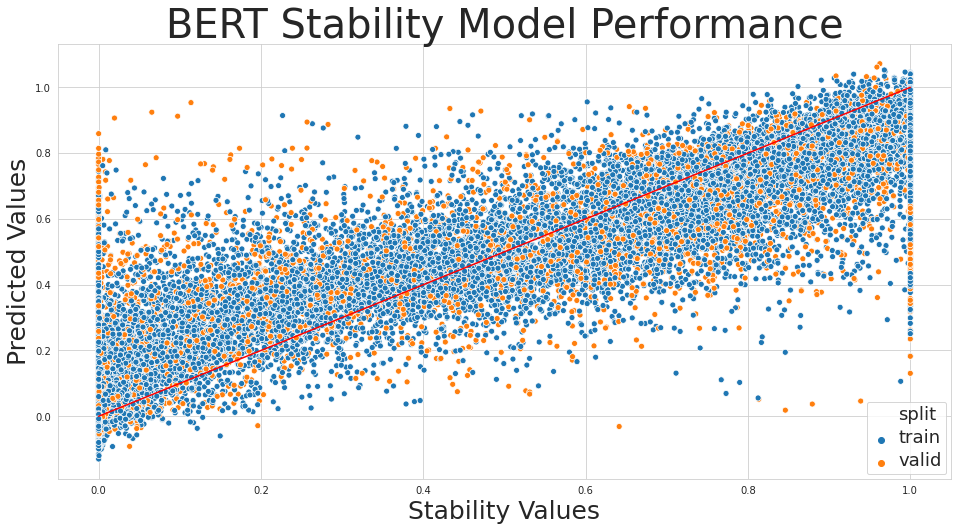

In [35]:
#Expression Model Performance Overview
plt.figure(figsize=(16,8))
sns.set_style("whitegrid")
ax = sns.scatterplot(x="stability", y="predicted", data=stability_plot_df_BERT, hue = "split")
plt.plot([0,1],[0,1], color = "r") # Add diagonal line
ax.axes.set_title("BERT Stability Model Performance",fontsize=40)
ax.set_xlabel("Stability Values",fontsize=25)
ax.set_ylabel("Predicted Values",fontsize=25)
plt.setp(ax.get_legend().get_texts(), fontsize='18') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='26') # for legend title

In [36]:
residuals_plot_df_BERT = residuals_df
residual_plot_df_BERT_predicted_residuals = residual_model.predict(residuals_plot_df_BERT)
residuals_plot_df_BERT['predicted'] = residual_plot_df_BERT_predicted_residuals

/home/john/my_python_env/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


[None, None]

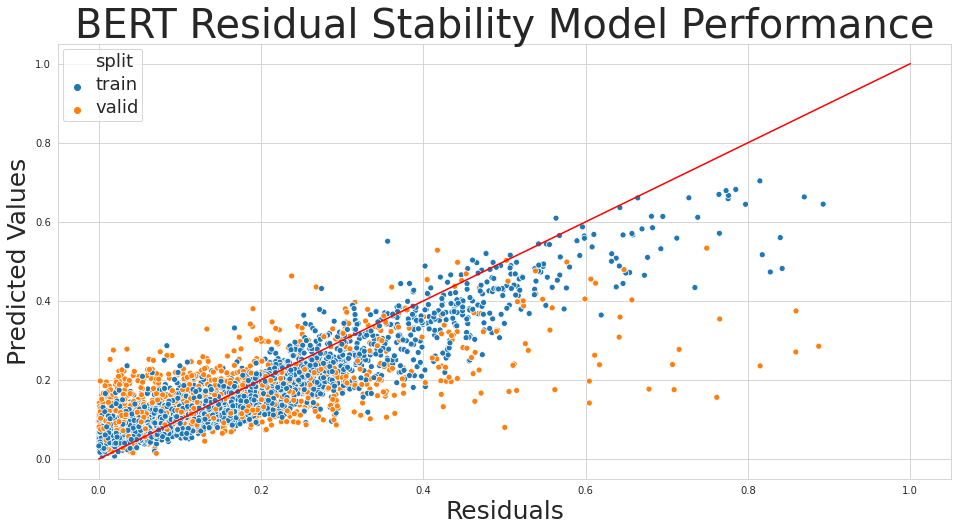

In [37]:
#Residual Model Performance Overview
plt.figure(figsize=(16,8))
ax = sns.scatterplot(x="residuals", y="predicted", data=residuals_plot_df_BERT, hue = "split")
plt.plot([0,1],[0,1], color = "r") # Add diagonal line
ax.axes.set_title("BERT Residual Stability Model Performance",fontsize=40)
ax.set_xlabel("Residuals",fontsize=25)
ax.set_ylabel("Predicted Values",fontsize=25)
plt.setp(ax.get_legend().get_texts(), fontsize='18') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='26') # for legend title

**_Normalized Evaluations_**

*Min and Max Intervals with True Labels* 

In [38]:
normalized_evaluation_table = get_evaluation_table(normalized_prediction_intervals, normalized_interval_size, y_test)
#normalized_evaluation_table

In [39]:
#Sort values by "true_values"
normalized_sorted_table = normalized_evaluation_table.sort_values("interval_size", ignore_index = True)
# Convert to tidy data format, making sure to keep the index
sorted_data_long = normalized_sorted_table.melt(value_vars=['min', 'true', 'max'], ignore_index=False).reset_index()
# Make variable a categorical, with categories ordered so as to make sense in the legend
sorted_data_long['variable'] = sorted_data_long['variable'].astype(pdtypes.CategoricalDtype(['min', 'true', 'max']))

[None, None]

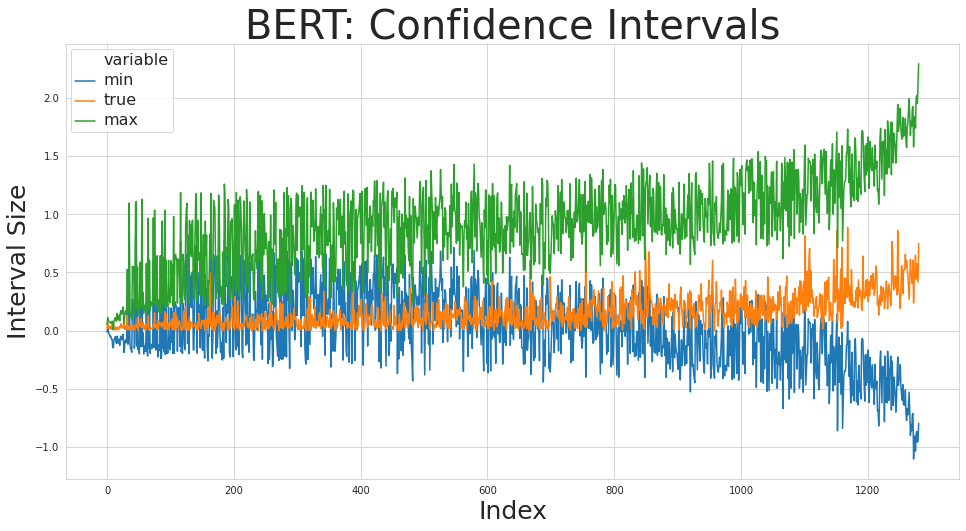

In [40]:
#Residual Model Performance Overview
plt.figure(figsize=(16,8))
sns.set_style("whitegrid")
ax = sns.lineplot(x="index", y="value", data=sorted_data_long, hue = "variable")

ax.axes.set_title("BERT: Confidence Intervals",fontsize=40)
ax.set_xlabel("Index",fontsize=25)
ax.set_ylabel("Interval Size",fontsize=25)
plt.setp(ax.get_legend().get_texts(), fontsize='16') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='24') # for legend title

In [41]:
y_test_abs = np.abs(y_test)
interval_sizes = np.abs(normalized_evaluation_table["interval_size"].values)
residuals_vs_intervals = pd.DataFrame({'true_residuals': y_test_abs.flatten(), 'confidence_interval': interval_sizes})
##residuals_vs_intervals

*Residuals vs Interval Size* 

Text(0, 0.5, 'True Residuals')

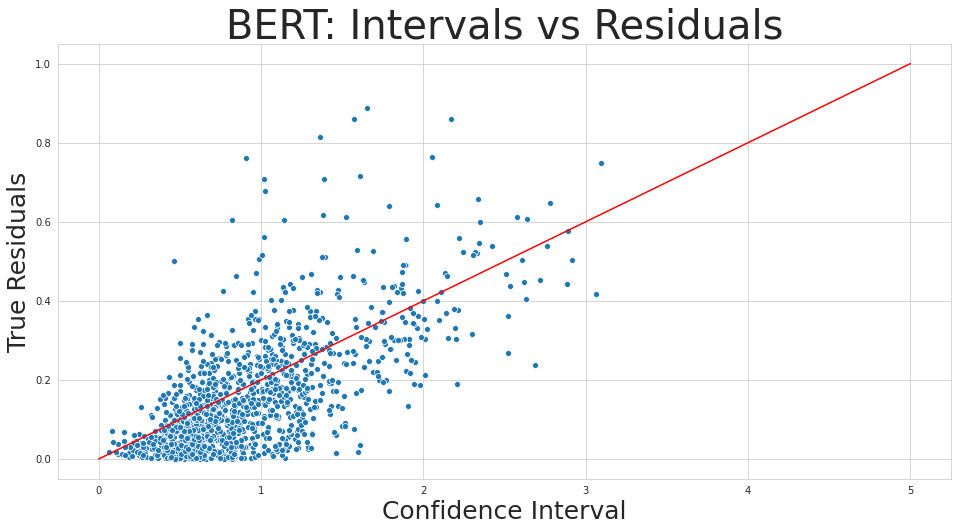

In [43]:
plt.figure(figsize=(16,8))
sns.set_style("whitegrid")
ax = sns.scatterplot(x="confidence_interval", y="true_residuals", data=residuals_vs_intervals)
plt.plot([0,5],[0,1], color = "r") # Add diagonal line
ax.axes.set_title("BERT: Intervals vs Residuals",fontsize=40)
ax.set_xlabel("Confidence Interval",fontsize=25)
ax.set_ylabel("True Residuals",fontsize=25)